In [1]:
BASE_PATH = "/content/drive/MyDrive/Académico/UNIR/MUQC/99 - TFM/dev"

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import random
import time
import pandas as pd
# usaremos "from pennylane import numpy as np" tras la instalación de PennyLane para el uso de los métodos de diferenciación automática
#import numpy as np
import matplotlib.pyplot as plt
#import tensorflow as tf

In [4]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 9.7 MB/s eta 0:00:00


In [5]:
from pennylane import numpy as np

In [6]:
N_QUBITS = 3

In [7]:
RANDOM_SEED = 1234

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
#tf.random.set_seed(RANDOM_SEED)

In [8]:
PCA_COMPONENTS = 8

In [9]:
df_tr_day_syn_resampled = pd.read_csv(BASE_PATH + "/dataset/tr_day_syn_tiny.csv")

In [10]:
df_test_day_syn_resampled = pd.read_csv(BASE_PATH + "/dataset/test_day_syn_tiny.csv")

In [11]:
x_tr = df_tr_day_syn_resampled.drop(columns = " Label").to_numpy()

In [12]:
y_tr = df_tr_day_syn_resampled[" Label"].to_numpy()

In [13]:
x_test = df_test_day_syn_resampled.drop(columns = " Label").to_numpy()

In [14]:
y_test = df_test_day_syn_resampled[" Label"].to_numpy()

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, train_size = 0.5, stratify = y_test)

In [17]:
from sklearn.preprocessing import MaxAbsScaler

In [18]:
scaler = MaxAbsScaler()
x_tr = scaler.fit_transform(x_tr)

x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)

In [19]:
x_test = np.clip(x_test, 0, 1)
x_val = np.clip(x_val, 0, 1)

In [20]:
from sklearn.decomposition import PCA

In [21]:
pca = PCA(n_components = PCA_COMPONENTS)

In [22]:
start = time.time()

xs_tr = pca.fit_transform(x_tr)
xs_test = pca.transform(x_test)
xs_val = pca.transform(x_val)

end = time.time()
print(f"Elapsed time: {end - start} s")

Elapsed time: 0.03251004219055176 s


In [23]:
import pennylane as qml

In [24]:
dev = qml.device("lightning.qubit", wires = N_QUBITS)

In [25]:
@qml.qnode(dev)
def kernel_circ(a, b):
  qml.AmplitudeEmbedding(
      a, wires = range(N_QUBITS), pad_with = 0, normalize = True)
  qml.adjoint(qml.AmplitudeEmbedding(
      b, wires = range(N_QUBITS), pad_with = 0, normalize = True))
  return qml.probs(wires = range(N_QUBITS))

(<Figure size 500x400 with 1 Axes>, <Axes: >)


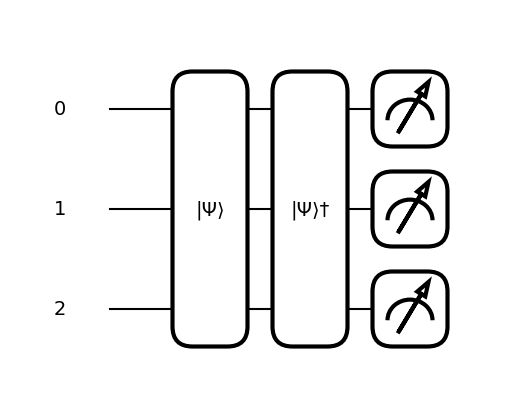

In [26]:
print(qml.draw_mpl(kernel_circ)(xs_tr[0], xs_tr[0]))

In [27]:
def qkernel(A, B):
  return np.array([[kernel_circ(a, b)[0] for b in B] for a in A])

In [28]:
from sklearn import svm

model = svm.SVC(kernel = qkernel)

In [29]:
start = time.time()

In [30]:
model.fit(xs_tr, y_tr)

SVC(kernel=<function qkernel at 0x7c485c541d80>)

In [31]:
end = time.time()
print(f"Elapsed time: {end - start} s")

Elapsed time: 41.3572142124176 s


In [32]:
from sklearn.metrics import accuracy_score

start = time.time()

tr_acc = accuracy_score(model.predict(xs_tr) >= 0.5, y_tr)
val_acc = accuracy_score(model.predict(xs_val) >= 0.5, y_val)
test_acc = accuracy_score(model.predict(xs_test) >= 0.5, y_test)

end = time.time()
print(f"Elapsed time: {end - start} s")

Elapsed time: 51.76856231689453 s


In [33]:
print("Train accuracy:", tr_acc)
print("Validation accuracy:", val_acc)
print("Test accuracy:", test_acc)

Train accuracy: 1.0
Validation accuracy: 0.9
Test accuracy: 1.0


In [34]:
from sklearn.metrics import confusion_matrix

In [35]:
output = model.predict(xs_test)
result = (output > 0.5).astype(float)

In [36]:
confusion_matrix(y_true = y_test, y_pred = result)

array([[9, 0],
       [0, 1]])

In [37]:
from sklearn.metrics import classification_report

print(classification_report(y_true = y_test, y_pred = result))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         1

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



In [38]:
from sklearn.metrics import roc_curve

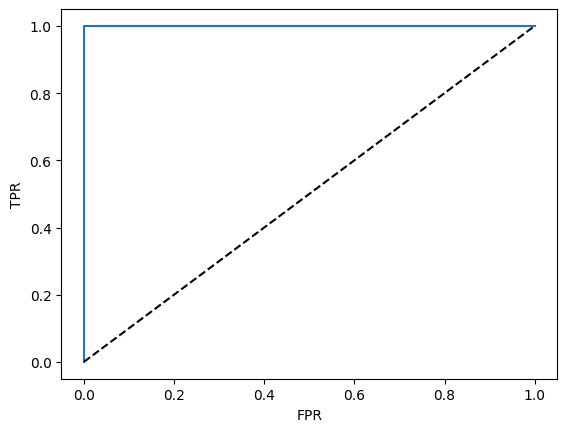

In [39]:
fpr, tpr, _ = roc_curve(y_test, output)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle = "--", color = "black")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.show()

In [40]:
from sklearn.metrics import auc

print(auc(fpr, tpr))

1.0
